# Project : Twitter Sentiment Analysis 
## Table of Content:
  * Introduction
  * Data preparation
  * Modeling
    * Hyperparameter tuning
    * Model Evaluation

## Introduction
**Sentiment Analysis** is NLP technique used to determine whether data is positive, negative or neutral. Sentiment analysis in Twitter tracks the problem of analyzing the tweets of the opinions the people express.
The most common type of Sentiment Analysis is “Polarity Detections” which involves classifying statements as positive, negative and neutral.


## Data Preparation

### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import re
import nltk
import seaborn as sns
from gensim.models.doc2vec import LabeledSentence
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import gensim
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Reading Data

In [ ]:
train_df = pd.read_csv('/content/twitter_training.csv', encoding="ISO-8859-1") #       
validation_df = pd.read_csv('/content/twitter_validation.csv', encoding="ISO-8859-1")

In [ ]:
train_df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
validation_df.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tomâs great auntie as âHayley canât get out of bedâ and told to his grandma, who now thinks Iâm a lazy, terrible person ð¤£"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp Iâve had Madeleine McCann in my c...


In [ ]:
train_df.columns = ['TweetID', 'Entity', 'Sentiment', 'TweetContent']
validation_df.columns = ['TweetID', 'Entity', 'Sentiment', 'TweetContent']

In [ ]:
train_df.head()

,TweetID,Entity,Sentiment,TweetContent
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
print("Train dataframe has {} rows, and {} columns".format(train_df.shape[0], train_df.shape[1]))

Train dataframe has 74681 rows, and 4 columns


In [ ]:
train_df.groupby('Sentiment').describe()

TweetID                                                           \
              count         mean          std   min     25%     50%      75%   
Sentiment                                                                      
Irrelevant  12990.0  5928.771363  3616.510316   5.0  2942.0  5153.0   9369.0   
Negative    22542.0  6760.267767  3479.188211   1.0  3825.0  7105.0   9384.0   
Neutral     18318.0  6494.270881  3959.853892   3.0  3173.0  6904.0  10011.0   
Positive    20831.0  6338.113821  3850.921687  12.0  2755.0  6001.0   9708.5   

                     
                max  
Sentiment            
Irrelevant  13200.0  
Negative    13194.0  
Neutral     13197.0  
Positive    13198.0

In [ ]:
#Check the unqiue classes in the target class
train_df['Sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

### Data preprocessing

In [ ]:
#Drop rows from column "Sentiment" that contain "Irrelevant" class
train_df = train_df[~train_df.Sentiment.str.contains("Irrelevant")]
train_df.drop(['Entity'], inplace=True, axis=1)
validation_df.drop(['Entity'], inplace=True, axis=1)

#Encoding target column
def encoding(df):
  encoded_col = []
  for ele in df['Sentiment']:
    if ele == 'Positive':
      encoded_col.append(0)
    elif ele == 'Negative':
      encoded_col.append(1)
    else:
      encoded_col.append(2)
  return np.array(encoded_col)

train_encoded_target = encoding(train_df)
validate_encoded_target = encoding(validation_df)

train_df['Sentiment'] = train_encoded_target
validation_df['Sentiment'] = validate_encoded_target

In [ ]:
train_df.duplicated().sum(), validation_df.duplicated().sum()
train_df.drop([19], axis=0, inplace=True)
# as we can see the train_df has duplicates, so we need to drop them
train_df.drop_duplicates(inplace=True)
train_df.duplicated().sum()

0

In [ ]:
train_df.isnull().sum()

TweetID           0
Sentiment         0
TweetContent    279
dtype: int64

In [ ]:
validation_df.isnull().sum()

TweetID         0
Sentiment       0
TweetContent    0
dtype: int64

In [ ]:
train_df.dropna(inplace=True, axis=0)
train_df.isnull().sum()

TweetID         0
Sentiment       0
TweetContent    0
dtype: int64

In [ ]:
train_df.head()

,TweetID,Sentiment,TweetContent
0,2401,0,I am coming to the borders and I will kill you...
1,2401,0,im getting on borderlands and i will kill you ...
2,2401,0,im coming on borderlands and i will murder you...
3,2401,0,im getting on borderlands 2 and i will murder ...
4,2401,0,im getting into borderlands and i can murder y...


In [ ]:
# Train dataframe shape after cleaning
train_df.shape

(59117, 3)

### Exploratory Data Analysis (EDA)

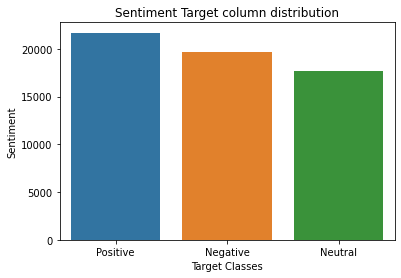

In [ ]:
target_col = ['Positive', 'Negative', 'Neutral']
plt.title("Sentiment Target column distribution")
plt.xlabel("Target Classes")
plt.ylabel("#occurences")
sns.barplot(x=target_col, y=train_df['Sentiment'].value_counts())

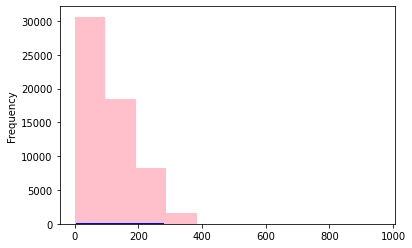

In [ ]:
# checking the distribution of tweets in the data
length_train = train_df['TweetContent'].str.len().plot.hist(color = 'pink', figsize = (6, 4))
length_test = validation_df['TweetContent'].str.len().plot.hist(color = 'blue', figsize = (6, 4))

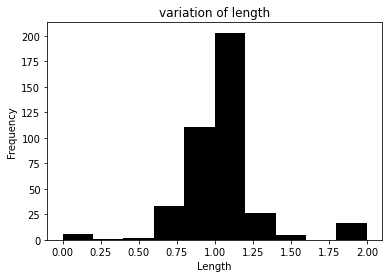

In [ ]:
train_df['len'] = train_df['TweetContent'].str.len()
validation_df['len'] = validation_df['TweetContent'].str.len()
train_df.groupby('len').mean()['Sentiment'].plot.hist(color = 'black', figsize = (6, 4),)
plt.title('variation of length')
plt.xlabel('Length')
plt.show()

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

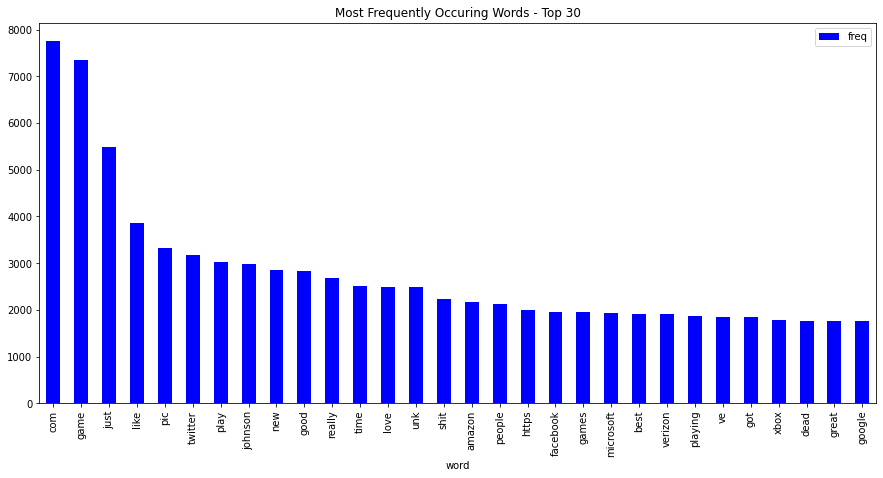

In [ ]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_df.TweetContent)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

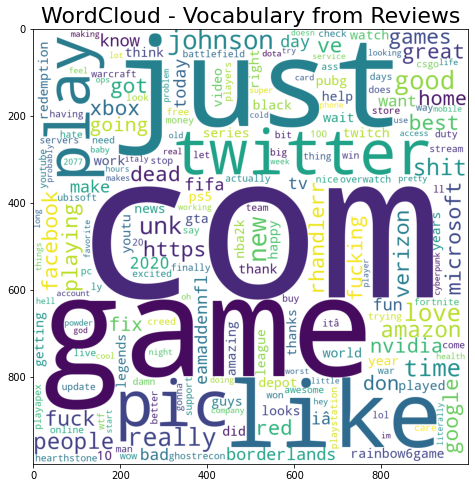

In [ ]:
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

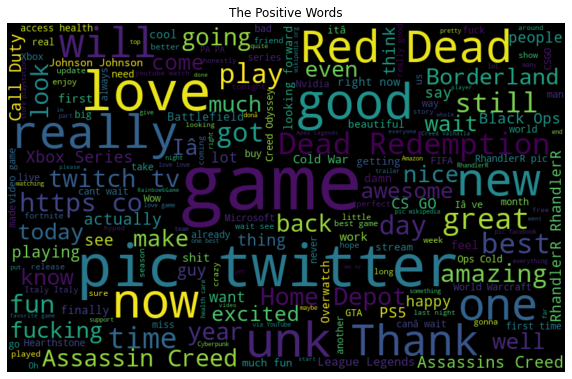

In [ ]:
normal_words =' '.join([text for text in train_df['TweetContent'][train_df['Sentiment'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positive Words')
plt.show()

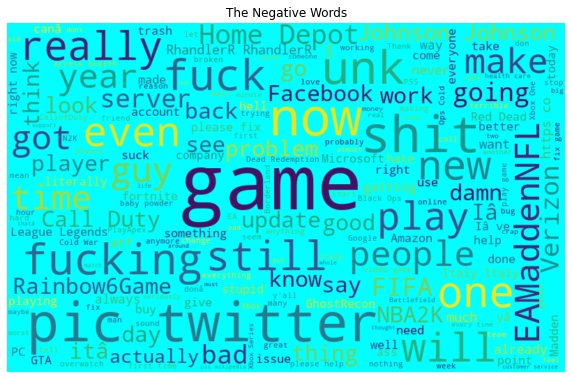

In [ ]:
negative_words =' '.join([text for text in train_df['TweetContent'][train_df['Sentiment'] == 1]])

wordcloud = WordCloud(background_color = 'cyan', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

## Modeling

### Word2Vec model

In [ ]:
# tokenizing the words present in the training set
tokenized_tweet = train_df['TweetContent'].apply(lambda x: x.split()) 

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train_df['TweetContent']), epochs=20)

(19110023, 23039360)

In [ ]:
print("Getting the similar words to the given POSITIVE word: /n")
model_w2v.wv.most_similar(positive = "twitter")

Getting the similar words to the given POSITIVE word: /n


[('com?', 0.55585777759552),
 ('irony', 0.5453013181686401),
 ('account.My', 0.5277568101882935),
 ('discriminating', 0.5256502628326416),
 ('censoring', 0.5216221213340759),
 ('user:', 0.5176053047180176),
 ('Whoopsidoodle,', 0.5153309106826782),
 ('coulda', 0.5071820020675659),
 ('facebook,', 0.500929057598114),
 ('rec', 0.49104729294776917)]

In [ ]:
print("Getting the similar words to the given NEGATIVE word: /n")
model_w2v.wv.most_similar(negative = "hate")

Getting the similar words to the given NEGATIVE word: /n


[('Mori.', 0.08964675664901733),
 ('youtu.be/3Y4guLLmfOs', 0.08208876848220825),
 ('fiverr.com/share/xkDQya.', 0.08036012202501297),
 ('ð\x9f¤\x93ð\x9f¤\x94.', 0.059937670826911926),
 ('..<unk>.playstation.com/', 0.052408136427402496),
 ('Beautiful!', 0.04347808286547661),
 ('zysola.blogspot.com/p/welcome.htmlâ\x80¦', 0.040642574429512024),
 ('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
  0.028030136600136757),
 ('youtu.be/fXUaF-Z1XCg', 0.023345056921243668),
 ('Afome', 0.01643429510295391)]

In [ ]:
train_corpus = []

for i in range(0, train_df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', train_df.iloc[i]['TweetContent'])
  review = review.lower()
  review = review.split()
  # stemming
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)

In [ ]:
test_corpus = []

for i in range(0, validation_df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', validation_df.iloc[i]['TweetContent'])
  review = review.lower()
  review = review.split()
  # stemming
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  test_corpus.append(review)

### Bag of Words model (BOW) 

In [ ]:
# creating bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus).toarray()
y = np.array(train_df.iloc[:, 1])
print("training data has {} rows, and {} columns".format(x.shape[0], x.shape[1]))
print("target column has {} rows".format(y.shape[0]))

training data has 59117 rows, and 2500 columns
target column has 59117 rows


### Preparing data for modeling

In [ ]:
# splitting the training data into 10 k-folds
Nfolds = 10
kf = KFold(n_splits=Nfolds, shuffle=True, random_state=42)
#Generating folds and making training and prediction for each of 10 folds
for train_index, test_index in kf.split(x, y):
    X_train, X_test = x[list(train_index)], x[list(test_index)]
    y_train, y_test = y[list(train_index)], y[list(test_index)]

In [ ]:
# standardization
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

### Random Forest Model

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RF_predictions = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Validation Accuracy :", model.score(X_test, y_test))

# confusion matrix
cm = confusion_matrix(y_test, RF_predictions)
print(cm)

Training Accuracy : 0.9671277675450137
Validation Accuracy : 0.911859245474539
[[1824   70   50]
 [ 130 2012   50]
 [ 151   70 1554]]


### XGBoost model

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGB_predictions = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Validation Accuracy :", model.score(X_test, y_test))

# confusion matrix
cm = confusion_matrix(y_test, XGB_predictions)
print(cm)

Training Accuracy : 0.6150246212833139
Validation Accuracy : 0.6152935205548976
[[1038  742  164]
 [ 168 1898  126]
 [ 278  796  701]]


### LGBM model

In [ ]:
model = LGBMClassifier()
model.fit(X_train, y_train)

lgbm_predictions = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Validation Accuracy :", model.score(X_test, y_test))

# confusion matrix
cm = confusion_matrix(y_test, lgbm_predictions)
print(cm)

Training Accuracy : 0.7135661391572379
Validation Accuracy : 0.6961597022500423
[[1316  445  183]
 [ 200 1839  153]
 [ 326  489  960]]


### Logsitic Regression Model

In [ ]:
# logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_model = LogisticRegression(multi_class='ovr', solver='liblinear')
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)

print("Training Accuracy :", model.score(X_train, y_train))
print("Validation Accuracy :", model.score(X_test, y_test))
# confusion matrix
cm = confusion_matrix(y_test, logistic_predictions)
print(cm)

Training Accuracy : 0.7135661391572379
Validation Accuracy : 0.6961597022500423
[[1482  248  214]
 [ 291 1727  174]
 [ 378  311 1086]]


### Hyperparameter tuning

In [ ]:
# Dictionary to store the best score of every model
cross_valid_scores = {}

In [ ]:
# # Random Forest
# parameters = {
#   "n_estimators": [5, 10, 15, 20, 25], 
#   "max_depth": [3, 5, 7, 9, 11, 13]
# }
# model_random_forest = RandomForestClassifier(
#   random_state=42,
#   class_weight='balanced',
# 
# grid_rf = GridSearchCV(
#   model_random_forest, 
#   parameters, 
#   cv=10,
#   scoring='accuracy',
# )
# best_rf = grid_rf.fit(X_train, y_train)
# print(f'Best parameters {best_rf.best_params_}')

In [ ]:
# # Xgboost
# parameters = {
#     'max_depth': [3, 5, 7, 9], 
#     'n_estimators': [5, 10, 15, 20, 25, 50, 100],
#     'learning_rate': [0.01, 0.05, 0.1]
# }
# model_xgb = XGBClassifier(random_state=42)
# grid_xgb = GridSearchCV(
#     model_xgb, 
#     parameters, 
#     cv=10,
#     scoring='accuracy',
# )

# best_xgb = grid_xgb.fit(X_train, y_train)
# print('-----')
# print(f'Best parameters {best_xgb.best_params_}')

In [ ]:
# #LGBM model
# parameters = {
#     'n_estimators': [5, 10, 15, 20, 25, 50, 100],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [7, 15, 31],
# }
# model_lgbm = LGBMClassifier(
#     random_state=42,
#     class_weight='balanced',
# )
# grid_lgbm = GridSearchCV(
#     model_lgbm, 
#     parameters, 
#     cv=10,
#     scoring='accuracy',
# )
# best_lgbm = grid_lgbm.fit(X_train, y_train)

# print('-----')
# print(f'Best parameters {grid_lgbm.best_params_}')

In [ ]:
# # Logistic Regression Model
# parameters = {
#     "C": [0.001, 0.01, 0.1, 1.0],
#     "penalty": ["l1", "l2"]
# }
# model_logistic_regression = LogisticRegression(
#     random_state=42,
#     class_weight="balanced",
#     solver="liblinear",
# )
# grid_log = GridSearchCV(
#     model_logistic_regression, 
#     parameters, 
#     cv=10,
#     scoring='accuracy',
# )
# best_log = grid_log.fit(X_train, y_train)
# print(f'Best parameters {grid_log.best_params_}')

### Ensembling

In [ ]:
model1 = RandomForestClassifier()
model2 = XGBClassifier()
model3 = LGBMClassifier()
model4 = LogisticRegression(multi_class='ovr', solver='liblinear')
model = VotingClassifier(estimators=[('rf', model1), ('log', model4)], voting='hard', weights=[2, 1])
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.9132126543732025

In [ ]:
final_predictions = model.predict(X_test)
# confusion matrix
cm = confusion_matrix(y_test, final_predictions)
print(cm)

[[1829   68   47]
 [ 132 2011   49]
 [ 142   75 1558]]


### Model Evaluation

we are evaluating the model using Macro Averageing

In [ ]:
# Functions to compute True Positives, True Negatives, False Positives and False Negatives
def true_positive(y_true, y_pred):
  tp = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 1 and yp == 1:
      tp += 1
  return tp

def true_negative(y_true, y_pred):
  tn = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 0 and yp == 0:
      tn += 1
  return tn

def false_positive(y_true, y_pred):
  fp = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 0 and yp == 1:
      fp += 1  
  return fp

def false_negative(y_true, y_pred):
  fn = 0
  for yt, yp in zip(y_true, y_pred):
    if yt == 1 and yp == 0:
      fn += 1
  return fn
  
def macro_precision(y_true, y_pred):
  # find the number of classes
  num_classes = len(np.unique(y_true))
  # initialize precision to 0
  precision = 0
  # loop over all classes
  for class_ in list(np.unique(y_true)):
    # all classes except current are considered negative
    temp_true = [1 if p == class_ else 0 for p in y_true]
    temp_pred = [1 if p == class_ else 0 for p in y_pred]
    # compute true positive for current class
    tp = true_positive(temp_true, temp_pred)
    # compute false positive for current class
    fp = false_positive(temp_true, temp_pred)
    # compute precision for current class
    temp_precision = tp / (tp + fp + 1e-6)
    # keep adding precision for all classes
    precision += temp_precision

  # calculate and return average precision over all classes
  precision /= num_classes

  return precision

In [ ]:
print("Voting classifier Performance {}".format(macro_precision(y_test, final_predictions)))
print("Random Forest Performance {}".format(macro_precision(y_test, RF_predictions)))    #Random forest

Voting classifier Performance 0.9150935697259222
Random Forest Performance 0.9136643526343345
